In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from typing import TypedDict,Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import HumanMessage,BaseMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command


In [2]:
load_dotenv()

True

In [3]:
# web search tool 
from langchain_tavily import TavilySearch
web_search_tool = TavilySearch(max_results=2)

In [4]:
# File management tool
from langchain_community.agent_toolkits import FileManagementToolkit

working_directory = './files'

file_management_tools =FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"]
).get_tools()


read_tool, write_tool, list_tool = file_management_tools

In [5]:
from langchain_core.tools import BaseTool,tool
from langgraph.prebuilt.interrupt import HumanInterruptConfig,HumanInterrupt
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt

In [6]:
def add_human_in_the_loop(toolhitl,interrupt_config: HumanInterruptConfig = None) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review."""

    if not isinstance(toolhitl, BaseTool):
        toolhitl = tool(toolhitl)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept":True,
            "allow_edit": True,
            "allow_respond":True
        }

    @tool(toolhitl.name,description=toolhitl.description,args_schema=toolhitl.args_schema)
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            'action_request':{
                "action":toolhitl.name,
                "args":tool_input
            },
            "config":interrupt_config,
            "description": "Please review the tool call"
        }

        response = interrupt([request])[0]

        # approve the tool call
        if response["type"] == "accept":
            tool_response = toolhitl.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = toolhitl.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response
    
    return call_tool_with_interrupt




In [7]:
#arxiv
import arxiv

@tool("arxiv_search")
def arxiv_search(query: str,max_results: int = 5) -> str:
    """
    Searches arXiv for papers matching the query.
    - query: keywords, authors or title
    - max_results: number of papers to return
    """
    try:
        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.Relevance
        )
        papers = []
        for result in search.results():
            pdf_url = result.pdf_url if hasattr(result,"pdf_url") else result.entry_id.replace("abs","pdf")
            papers.append(
                f"Title: {result.title}\n"
                f"Authors: {','.join(a.name for a in result.authors)}\n"
                f'Published: {result.published.date()}\n'
                f"Abstract: {result.summary.strip()}\n"
                f"Link: {result.entry_id}\n"
                f"PDF: {pdf_url}\n"
                + "-"*80

            )
        if not papers:
            return f"No results found for '{query}"
        return "\n".join(papers)
    except Exception as e:
        return f"Error during arXiv search: {e}"
    



In [8]:
result = arxiv_search("Quantum Machine Learning")

C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_11032\2627632007.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = arxiv_search("Quantum Machine Learning")
C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_11032\2323917343.py:18: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


In [9]:
#wikipedia
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(load_all_available_meta=True))

In [10]:
#youtube
from langchain_community.tools import YouTubeSearchTool
youtube_tool = YouTubeSearchTool()

In [11]:
youtube_tool.run("CampusX")

"['https://www.youtube.com/shorts/dMBVuRYzAKs', 'https://www.youtube.com/watch?v=4FFspU4riHk&pp=ygUHQ2FtcHVzWA%3D%3D']"

In [12]:
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import Tool,tool
python_repl = PythonREPL()
# You can create the tool to pass to an agent
from pydantic import BaseModel

class PythonREPLInput(BaseModel):
    code: str

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Input should be Python code as a string.",
    args_schema=PythonREPLInput,
    func=lambda code: python_repl.run(code)  # map `code` -> REPL
)


In [13]:
from langgraph.store.memory import InMemoryStore
#from langgraph.store.sqlite import SqliteStore
from langchain_core.runnables import RunnableConfig
from langgraph.config import get_store
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import TypedDict
from typing import Optional

store = InMemoryStore() 

In [14]:
@tool
def get_user_info(config: RunnableConfig) -> str:
    """Look up user info."""
    store = get_store()
    user_id = config['configurable'].get("user_id")
    user_info = store.get(("users",),user_id)
    return str(user_info.value) if user_info else "Unknown user"


In [ ]:
from typing import Dict, Any
    

@tool 
def save_user_info(user_info: Dict[str, Any], config: RunnableConfig) -> str:
    """
    Save arbitrary user info as key-value pairs.
    Always pass `user_info` as a JSON object (not a string).
    Example: {"name": "John", "age": 30}
    """
    store = get_store()
    user_id = config['configurable'].get("user_id")
    store.put(("users",), user_id, user_info)
    return "Successfully saved user info "

In [16]:
# tools
tools = [add_human_in_the_loop(repl_tool),arxiv_search,wikipedia_tool,youtube_tool,read_tool, add_human_in_the_loop(write_tool), list_tool,web_search_tool,save_user_info,get_user_info]

In [17]:
#llm
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')
llm_with_tools = llm.bind_tools(tools)


GRAPH BUILDING

In [18]:
class State(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]

In [19]:
from datetime import datetime
CURRENT_TIME_IST = datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z")


system_prompt = f"""
You are an intelligent reasoning agent that helps users by combining natural conversation 
with external tools when needed.

Current date/time: {CURRENT_TIME_IST}

CORE BEHAVIOR
- Think step by step privately. Do NOT reveal chain-of-thought; only show final answers and short explanations.
- Prefer external tools for time-sensitive, date-related, or “latest” queries. If a tool is available and relevant, USE IT.
- When any tool is used, BASE YOUR FINAL ANSWER ONLY ON THE TOOL OBSERVATIONS. Do not mix in prior knowledge that conflicts with tools.
- If tools fail or are insufficient, say so and propose the next best tool/action.

TEMPORAL & FRESHNESS RULES
- If the user mentions a year/date (e.g., 2025) or asks for "latest/current/today/this year", you MUST consult a web/search tool first.
- Do NOT claim “this hasn’t happened yet” or “it’s a future date” unless you have explicitly checked the current date AND the tool results confirm it (e.g., no results or explicit statements about future scheduling).


### Reasoning Framework
Follow the ReAct reasoning loop:
1. **Thought** — explain what you are thinking or planning.
2. **Action** — choose the correct tool to use.
3. **Action Input** — provide the exact structured input for the tool.
4. **Observation** — read the tool's result and update your reasoning.

Repeat this loop until you can confidently respond to the user.

### Style & Tone
- Be concise but complete.
- Use plain language that non-technical users can understand.
- If user input is ambiguous, ask clarifying questions before acting.
- Never hallucinate tool outputs. If unsure, say so.
"""


In [20]:
def planner_node(state):
    user_query = state['messages']

    planner_prompt = ChatPromptTemplate([
        ('system',system_prompt),
        MessagesPlaceholder(variable_name='messages')
    ])

    planner = planner_prompt | llm_with_tools
    result = planner.invoke({'messages': state['messages']})


    return ({'messages':result}) 
    

In [21]:
graph = StateGraph(State)
checkpointer = InMemorySaver()
tool_node = ToolNode(tools)
graph.add_node('planner_node',planner_node)
graph.add_node('tools',tool_node)

graph.add_edge(START,'planner_node')
graph.add_conditional_edges('planner_node',tools_condition)
graph.add_edge('tools','planner_node')
graph = graph.compile(checkpointer=checkpointer,store=store)

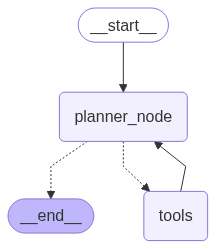

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
initial_state = {
    "messages": [HumanMessage(content="I like to play Basketball")]
}

config = {"configurable": {"thread_id": "t2" ,"user_id": "user_23"}}

In [31]:
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

In [32]:
chunk

{'messages': [HumanMessage(content='hii i am john , please explain LLM in 5 sentences ', additional_kwargs={}, response_metadata={}, id='d7c60e5c-2865-4f03-8e42-7abbfc563e0a'),
  AIMessage(content='Hi John! LLM stands for Large Language Model. These are powerful AI models trained on vast amounts of text data. They learn to understand, generate, and predict human language. LLMs can perform various tasks like answering questions, writing different kinds of creative content, and translating languages. They are at the core of many modern AI applications.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--f1d751d1-418b-405b-84b3-6e1540b4de1f-0', usage_metadata={'input_tokens': 2195, 'output_tokens': 113, 'total_tokens': 2308, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 45}}),
  HumanMessage(content='hii i am john

In [33]:
store.get(("users",), "user_23")

Item(namespace=['users'], key='user_23', value={'hobby': 'Basketball', 'name': 'John'}, created_at='2025-08-31T19:16:11.288340+00:00', updated_at='2025-08-31T19:16:11.288340+00:00')

In [23]:
print(chunk['messages'][1])



content='' additional_kwargs={'function_call': {'name': 'python_repl', 'arguments': '{"code": "\\ndef is_prime(num):\\n    if num < 2:\\n        return False\\n    for i in range(2, int(num**0.5) + 1):\\n        if num % i == 0:\\n            return False\\n    return True\\n\\nprint(is_prime(7))\\nprint(is_prime(10))\\nprint(is_prime(2))\\nprint(is_prime(1))\\nprint(is_prime(23))\\nprint(is_prime(49))\\n"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--86dd4bf9-19f6-4037-a009-305e18e2f64c-0' tool_calls=[{'name': 'python_repl', 'args': {'code': '\ndef is_prime(num):\n    if num < 2:\n        return False\n    for i in range(2, int(num**0.5) + 1):\n        if num % i == 0:\n            return False\n    return True\n\nprint(is_prime(7))\nprint(is_prime(10))\nprint(is_prime(2))\nprint(is_prime(1))\nprint(is_prime(23))\nprint(is_prime(49))\n'}, 'id': '5d7091fc-3e6

In [24]:
from langgraph.types import Command
user_input = input("Do you accept: ?")

for chunk in graph.stream(
    Command(resume=[{"type": user_input}]),
    config
):
    print(chunk)
    print("\n")

Python REPL can execute arbitrary code. Use with caution.


{'tools': {'messages': [ToolMessage(content='True\nFalse\nTrue\nFalse\nTrue\nFalse\n', name='python_repl', id='277e4232-a778-4516-9df3-5cbe33cccdd7', tool_call_id='5d7091fc-3e64-45c4-a80c-f59468f70d91')]}}


{'planner_node': {'messages': AIMessage(content=['The following Python code defines a function `is_prime` that checks if a number is prime. It then tests the function with several examples:', '```python\ndef is_prime(num):\n    if num < 2:\n        return False\n    for i in range(2, int(num**0.5) + 1):\n        if num % i == 0:\n            return False\n    return True\n\n# Test cases\nprint(is_prime(7))   # Expected: True\nprint(is_prime(10))  # Expected: False\nprint(is_prime(2))   # Expected: True\nprint(is_prime(1))   # Expected: False\nprint(is_prime(23))  # Expected: True\nprint(is_prime(49))  # Expected: False\n```'], additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-fla

In [24]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='tell me about pyramid in detail and save it in a txt file', additional_kwargs={}, response_metadata={}, id='3d461e2c-da90-4ac8-a295-a358610987ae'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "pyramid"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--49e40eaf-89df-4ccd-adbb-30b829354499-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'pyramid'}, 'id': '613a6772-c5b7-4248-a375-c8da09528e03', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1696, 'output_tokens': 63, 'total_tokens': 1759, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 49}}), ToolMessage(content='Page: Pyramid\nSummary: A pyramid (from Ancient Greek  πυραμίς (puramís) \'pyramid\', from the Egyptian pir-em-us, the vertical height of the

In [3]:
from langchain_community.document_loaders import YoutubeLoader
loader = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=MvNdgmM7uyc", add_video_info=False
)

In [10]:
from youtube_transcript_api import YouTubeTranscriptApi

ytt_api = YouTubeTranscriptApi()
transcript = ytt_api.fetch("MvNdgmM7uyc").to_raw_data()

In [17]:
output = ""
for t in transcript:
    output += t['text']
    
print(output)

hi this is Lan from Lang chain I want totalk about using Lang graph for codeGeneration Um so co- generation is oneof the really interesting applicationsof llms like we've seen projects likeGitHub co-pilot become extremely popularum and a few weeks ago a paper came outum by the folks at codium AI calledAlpha codium and this was really coolpaper in particular because itintroduced this ideaof doing code generation using what youcan think of as like flow engineering soinstead of just like an llm a codingprompt like solve this problem and asolution what it does is it generates aset of solutions ranks them so that'sfine that's like kind of standard likekind of prompt response style flow butwhat it does here that I want to drawyour attention to is if it actuallytests that code in a few different wayson public tests and on AI generatedtests and the key point is this itactually iterates and tries to improvethe solution based upon those testresults so that was reallyinteresting and a tweet came 

In [22]:
from langgraph.store.memory import InMemoryStore
from langchain_core.runnables import RunnableConfig
from langgraph.config import get_store
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import TypedDict

store = InMemoryStore() 



In [115]:
store.get(("istyle",), "use3")

Item(namespace=['istyle'], key='use3', value={'tone': 'casual', 'format': '', 'language': ''}, created_at='2025-08-31T15:59:33.261498+00:00', updated_at='2025-08-31T15:59:33.261498+00:00')

In [ ]:
# Namespaces in store
("users", user_id)         # user profile
("preferences", user_id)   # preferences
("knowledge", user_id)     # facts
("tasks", user_id)         # goals
("interactions", user_id)  # style/history
("domain", user_id)        # domain-specific info
("world", user_id)         # external/tool context
("sessions", user_id)      # session summaries
